In [1]:
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
import statsmodels
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

# CWAS Getting Acquainted

In this notebook, we'll be getting acquainted with the CWAS analysis that Riaz coordinated and that we'll assist with downstream analysis/verification.

## So what even is this CWAS thing?

Riaz has explained this a number of times, but I'm still slow in understanding, so I want to rehash what I remember/know here. Ryan used this approach in a genetics study here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961723/

Fundamentally, the issue is that there hasn't been an "unbiased" way to approach noncoding genetic studies to this point. You can examine individual noncoding SVs in particular contexts (e.g. "enhancers in X tissue"), but this doesn't enable a genome-wide dissection. A CWAS leverages all _categories_ of alterations that are known in the genome. This uses a variety of functional annotations (e.g. "on TAD boundaries") that provide a way of assessing if there is some "target" of genetic variation in a disease phenotype.

The idea is that for each category, we assign a 0/1 for each variant if that variant is part of the category. We then proceed with the classic GWAS approach, but we instead focus on the categories instead of variants (i.e. the CWAS part).

But categories are inherently not independent--the approach identifies the effective number of tests using an eigenvector based method that is far above my head. But effectively, it incorporates test-test correlation to devise an effective number of statistical tests for use in multiple test correction.

## Alright, let's try reading this data in

We'll read in the data from Riaz's CWAS study and get acquainted with it.

In [2]:
example_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt', sep='\t')




In [3]:
example_svs.head(2)

,SV,chrom,start,end,category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...


This file just enumerates all the SVs that are in the cases and controls and their corresponding category assignments. We can see that one SV can have multiple category assignments:

In [4]:
example_svs['SV'].value_counts()

PedSV.2.5.2_DEL_chr5_5885     384
PedSV.2.5.2_DEL_chr7_1547     256
PedSV.2.5.2_DEL_chr10_3802    248
PedSV.2.5.2_CPX_chr7_314      240
PedSV.2.5.2_DEL_chr19_1499    240
                             ... 
PedSV.2.5.2_DEL_chr15_5528      4
PedSV.2.5.2_DEL_chr15_5537      4
PedSV.2.5.2_DEL_chr15_5678      4
PedSV.2.5.2_DEL_chr16_954       4
PedSV.2.5.2_CTX_chr6_1          4
Name: SV, Length: 6626, dtype: int64

In [5]:
example_svs[example_svs['SV'] == "PedSV.2.5.2_CTX_chr6_1"]

,SV,chrom,start,end,category
74799,PedSV.2.5.2_CTX_chr6_1,chr6,118926919,118926920,ANY.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EX...
91103,PedSV.2.5.2_CTX_chr6_1,chr6,118926919,118926920,ANY.RARE.ANY.ANY.ANY.protein_coding
106654,PedSV.2.5.2_CTX_chr6_1,chr6,118926919,118926920,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
119018,PedSV.2.5.2_CTX_chr6_1,chr6,118926919,118926920,ANY.SINGLETON.ANY.ANY.ANY.protein_coding


In [6]:
noncoding_test = pd.read_csv('data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt', sep='\t')
coding_test = pd.read_csv('data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt', sep='\t')

In [7]:
noncoding_test

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,neuroblastoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,neuroblastoma_ABC_MAX_enhancer,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,neuroblastoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,neuroblastoma_chromHMM15_EnhBiv,NaN,NaN,NaN,NaN


In [8]:
example_results = pd.read_csv('data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt', sep='\t')

This file lists an example results file for a CWAS that includes only singleton SVs affecting coding regions.

In [9]:
example_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968


These columns all make sense to me. This essentially gives the summary statistics for each singleton category. We can convert this into a volcano plot as Riaz did:

(-2.0, 2.0)

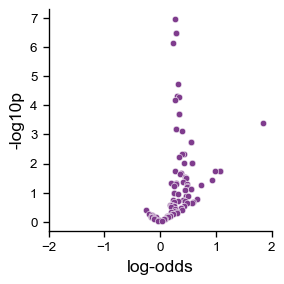

In [10]:
fig, ax = plt.subplots(1, figsize = (3,3))
sns.scatterplot(x = 'point_estimate', y = 'negative_log10_p_value', data = example_results)
sns.despine(ax = ax)
ax.set_ylabel('-log10p')
ax.set_xlabel('log-odds')
ax.set_xlim([-2, 2])

This indeed replicates what Riaz had. Let's take a brief look at noncoding in neuroblastoma:

In [11]:
example_noncoding = pd.read_csv('data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt', sep='\t')

In [12]:
example_noncoding.shape

(1783, 20)

So noncoding analyses have significantly more categories (makes sense)

(-2.0, 2.0)

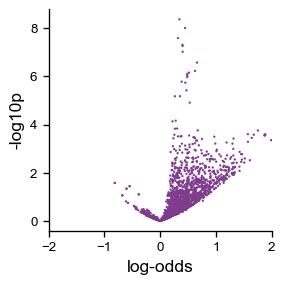

In [13]:
fig, ax = plt.subplots(1, figsize = (3,3))
sns.scatterplot(x = 'point_estimate', y = 'negative_log10_p_value', data = example_noncoding, ec = None, s = 3)
sns.despine(ax = ax)
ax.set_ylabel('-log10p')
ax.set_xlabel('log-odds')
ax.set_xlim([-2, 2])

Pretty much all of the highest signal results come from the TAD boundaries around neuroblastoma, which is what Riaz is very interested in.

# What's next?

Now we come in--working with Riaz to actually assign interpretability to these results. There are a few approaches to this:

1. Validating that these signals are in fact real. It seems like the callset is approaching some reasonable quality, so I'll leave this to Riaz and Ryan.
2. Post-hoc trying to group together categories. Essentially, we should expect to see grouping together of correlated categories (trying to determine some interpretation with thoughts alone)
3. Some variation of a GO term analysis for genes involved in the leading singleton categories. This is effectively trying to determine if the genes implicated in these categories are part of some higher order pathway. For categories involving TADs, this analysis would probably need to include genes in the TAD itself.
4. Evaluation of TPM data for a subset of the GMKF neuroblastoma cases. This is effectively seeing if these signals actually translate to meaningful adjustments in RNA expression (will be difficult but fun to do, I think)